In [1]:
import sys, os
from glob import glob
import re
import time
from datetime import datetime 
import pydot 
# import graphviz

from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

import tensorflow as tf
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sb
import psutil

# Directly importing from tf.keras for convenience
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Dropout, MaxPool1D, AveragePooling1D, MaxPool2D,GlobalMaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling2D, concatenate

from scipy.special import softmax
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("--------- Sys Info ---------")
print(sys.version)
print(" ")
print("--------- Utility Info ---------")
print("Cpu Usage: " + str(psutil.cpu_percent()) + "%")
print("Memory Usage:")
print(psutil.virtual_memory())
print(" ")
print("--------- Package Versions ---------")
print("Tensorflow Version: " + tf.__version__)
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Matplotlib Version: " + mpl.__version__)
print(" ")
print("--------- Local Hardware ---------")
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

--------- Sys Info ---------
3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]
 
--------- Utility Info ---------
Cpu Usage: 5.8%
Memory Usage:
svmem(total=137302384640, available=123731296256, percent=9.9, used=13571088384, free=123731296256)
 
--------- Package Versions ---------
Tensorflow Version: 2.0.0
Numpy Version: 1.17.4
Pandas Version: 0.25.3
Matplotlib Version: 3.1.3
 
--------- Local Hardware ---------


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5466237411590357745, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9027596452
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 13756007652139240625
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:0a:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 9027596452
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 11702061430630896919
 physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:41:00.0, compute capability: 7.5"]

In [8]:
def create_training_sequence(n, d):
  scaler = StandardScaler()
  dataset = []
  for i in range(0, n):
    power = np.random.normal(2, 1, 1)[0]
    base1 = np.random.normal(2, 0.5, 1)[0]
    base2 = 0
    sample = []
    for j in range(1, d):
      base1 += (j*2)
      base2 += base1**(power**2)
      sample.append(base1 + base2)

    sample = np.array(sample)
    sample -= np.mean(sample)
    sample /= np.std(sample)

    dataset.append(sample)

  dataset = np.array(dataset)

  return dataset

test = create_training_sequence(1, 24)
print(test)
print(type(test))
print(test.shape)

[[-0.63082913 -0.63081028 -0.63073143 -0.63048276 -0.62984107 -0.62840811
  -0.62553506 -0.62023337 -0.61107162 -0.59605873 -0.57251315 -0.53691843
  -0.48476474 -0.41037669 -0.30672724 -0.1652377   0.02443605  0.27463125
   0.59991985  1.01736395  1.54678512  2.21104764  3.03635563]]
<class 'numpy.ndarray'>
(1, 23)


In [9]:
def sequence_data_window(arr, start, window_size):
  end = start + window_size

  if ((end - start) % 2 != 0 or (end - start) < 0):
    raise Exception('Need evenly sized window')

  output = [np.array([arr[i]]).reshape(1,-1) for i in range(start, end)]
  return output

test = sequence_data_window(test[0], 4, 8)
print(test)
print(type(test))
print(type(test[0]))
print(test[0].shape)

[array([[-0.62984107]]), array([[-0.62840811]]), array([[-0.62553506]]), array([[-0.62023337]]), array([[-0.61107162]]), array([[-0.59605873]]), array([[-0.57251315]]), array([[-0.53691843]])]
<class 'list'>
<class 'numpy.ndarray'>
(1, 1)


In [0]:
def prepare_input_layers(window_size, d):
  output = []
  for i in range(int(window_size)):
    output.append(Input(shape=(d,)))
  return output

def compile_model(model, 
                learning_rate, 
                momentum,
                loss_function,
                metrics,
                optim):
  
    model.compile(optimizer=optim(learning_rate=learning_rate, momentum=momentum, nesterov=True), loss=loss_function, metrics=metrics)
    return model

def build_model(input_dim,
                denseWidth,
                activation_function,
                output_activation,
                window_size):

    model_inputs = prepare_input_layers(window_size, input_dim)
    layers = []
    model_outputs = []

    for i in range(np.log2(window_size).astype('int64')):
      layer_arr = []
      for j in range(int(window_size / 2**(i+1))):
        if i == 0:
          concat = concatenate([model_inputs[j*2], model_inputs[j*2+1]])
          layer_arr.append(Dense(denseWidth, activation_function)(concat))
        elif (i > 0) and (i < (np.log2(window_size).astype('int64') - 1)):
          concat = concatenate([layers[i - 1][j*2], layers[i - 1][j*2+1]])
          layer_arr.append(Dense(denseWidth, activation_function)(concat))
        else:
          concat = concatenate([layers[i - 1][j*2], layers[i - 1][j*2+1]])
          model_outputs.append(Dense(1, output_activation)(concat))

      layers.append(layer_arr)

    model = Model(model_inputs, model_outputs[0])
 
    return model

def train_wavenet(model, window_size, callbacks):
  test = create_training_sequence(1, 128)
  model_History = None
  for epoch in range(1):
    for i in range(0, len(test[0])-(window_size + 1)):
      print(i)
      test_sequence = sequence_data_window(test[0], i, window_size)
      print('-----------------------------')
      print(test_sequence)
      print(np.array([test[0][i+window_size+1]]))
      model_History = model.fit(test_sequence, np.array([test[0][i+window_size+1]]), epochs=1, batch_size = 1, callbacks=callbacks, verbose=True)
      print(model.predict(test_sequence)[0])
  return model_History


In [0]:
earlyStoppingCallback = EarlyStopping(monitor='loss', patience=3)

input_dim = 1
denseWidth = 25
activation_function = 'relu'
output_activation = 'linear'
window_size = 16

test_wavenet = build_model(input_dim,
                          denseWidth,
                          activation_function,
                          output_activation,
                          window_size)

test_wavenet = compile_model(test_wavenet, 0.05, 0.6, 'MSE', ['mse'], SGD)

In [14]:
test_wavenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

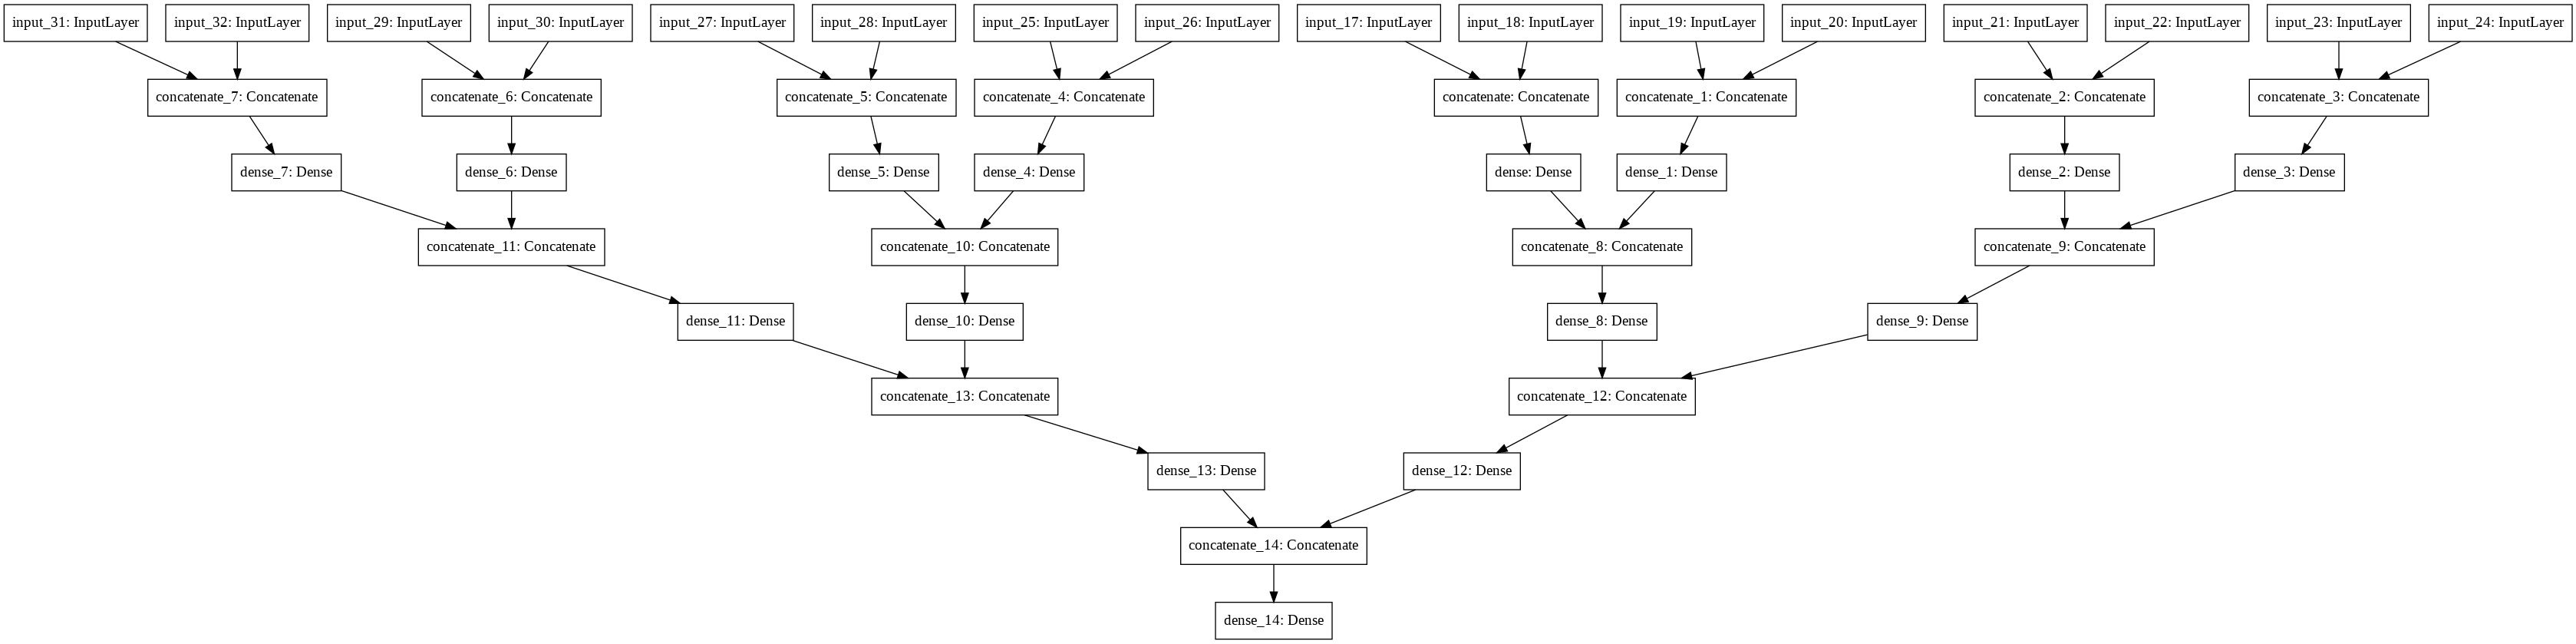

In [0]:
plot_model(test_wavenet)

In [16]:
model_History = train_wavenet(test_wavenet, 16, [earlyStoppingCallback])

0
-----------------------------
[array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]])]
[-0.28839328]
Train on 1 samples
1/1 [==============================] - 2s 2s/sample - loss: 0.1338 - mse: 0.1338
[-0.09182878]
1
-----------------------------
[array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]]), array([[-0.28839328]])]
[-0.28839328]
Train on 1 samples
1/1 [